In [1]:
import shutil
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyarrow.parquet as pq

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window
from pyspark.sql.functions import col, isnull, count, when, substring, coalesce, from_json, size, avg, expr, concat_ws
from pyspark.sql.types import ArrayType, StringType, StructType, StructField, DoubleType, IntegerType
from functools import reduce

In [2]:
# 가상 환경의 Python 경로를 지정
python_path = "C:/Users/admin/anaconda3/envs/my_conda_01/python.exe"

# Spark 세션 생성
spark = SparkSession.builder \
    .appName("voice_metadata integrating operation") \
    .config("spark.driver.memory", "5g") \
    .config("spark.executor.memory", "5g") \
    .config("spark.driver.maxResultSize", "3g") \
    .config("spark.pyspark.python", python_path) \
    .config("spark.local.dir", "D:/spark_tmp") \
    .getOrCreate()

# SparkContext 가져오기
sc = spark.sparkContext

In [3]:
# Spark 중간 파일이 저장되는 경로 확인
current_spark_local_dir = spark.conf.get("spark.local.dir", "Not Set")
print("Spark local directory:", current_spark_local_dir)

Spark local directory: D:/spark_tmp


In [4]:
# 업로드된 Parquet 파일을 읽어서 Spark DataFrame으로 변환
file_path = 'D:/DATA_PREPROCESS/FIRESTORE_DATAS/sample_voice_metadata_230918/public_sample_voice_metadata_230920.parquet'
spark_df = spark.read.parquet(file_path)

In [9]:
spark_df.printSchema()

root
 |-- ad_name: string (nullable = true)
 |-- attend: string (nullable = true)
 |-- is_passed: string (nullable = true)
 |-- ad_script: string (nullable = true)
 |-- ad_title: string (nullable = true)
 |-- birth_year: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- is_test: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- job: string (nullable = true)
 |-- language: string (nullable = true)
 |-- perfect: double (nullable = true)
 |-- excepted_age_array: string (nullable = true)
 |-- collection: string (nullable = true)
 |-- ad_duration: string (nullable = true)
 |-- level: string (nullable = true)
 |-- participant_count: long (nullable = true)
 |-- accuracy_array: string (nullable = true)
 |-- stt_text_array: string (nullable = true)
 |-- created_timestamp_array: string (nullable = true)
 |-- average_accuracy_by_ad: double (nullable = true)
 |-- average_accuracy_by_user: double (nullable = true)
 |-- pass_rate_by_user: double (nullable = true

In [5]:
# DataFrame의 전체 row 수를 확인
total_rows = spark_df.count()

# 'Collection' 필드의 각 범주(Point, Memorization)에 대한 row 수를 확인
point_count = spark_df.filter(col("Collection") == "Point").count()
memorization_count = spark_df.filter(col("Collection") == "Memorization").count()

# 결과 출력
print(f"Total Rows: {total_rows}")
print(f"Point Count: {point_count}")
print(f"Memorization Count: {memorization_count}")

Total Rows: 10000
Point Count: 5000
Memorization Count: 5000


In [6]:
# 데이터 분할 비율 설정
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

fractions = {
    "Point": train_ratio,
    "Memorization": train_ratio
}

# 훈련 데이터셋 생성
# seed는 난수 생성기 초기값으로 42는 해당 코드를 언제 실행하든 같은 방식으로 샘플링
# 특별한 의미는 없으나 데이터 과학에서 몇몇 알려진 숫자를 임의로 사용할 뿐
train_df = spark_df.sampleBy("Collection", fractions, seed=42)

# 남은 데이터로부터 검증 및 테스트 데이터셋 생성
remaining_df = spark_df.subtract(train_df)
fractions = {
    "Point": val_ratio / (1 - train_ratio),
    "Memorization": val_ratio / (1 - train_ratio)
}
val_df = remaining_df.sampleBy("Collection", fractions, seed=42)

test_df = remaining_df.subtract(val_df)

# 각 데이터셋 분할의 수를 출력
print(f"Training set count: {train_df.count()}")
print(f"Validation set count: {val_df.count()}")
print(f"Test set count: {test_df.count()}")

Training set count: 7104
Validation set count: 1475
Test set count: 1421


In [7]:
# 데이터셋을 저장할 디렉터리 경로 설정
train_path = 'D:/DATA_PREPROCESS/FIRESTORE_DATAS/sample_voice_metadata_230918/ETRI_VOICE_DATASET/train.parquet'
val_path = 'D:/DATA_PREPROCESS/FIRESTORE_DATAS/sample_voice_metadata_230918/ETRI_VOICE_DATASET/val.parquet'
test_path = 'D:/DATA_PREPROCESS/FIRESTORE_DATAS/sample_voice_metadata_230918/ETRI_VOICE_DATASET/test.parquet'

# 각 DataFrame을 해당 디렉터리에 Parquet 형태로 저장
train_df.write.mode('overwrite').parquet(train_path)
val_df.write.mode('overwrite').parquet(val_path)
test_df.write.mode('overwrite').parquet(test_path)

In [8]:
def calculate_category_ratio(df, column_name):
    total_count = df.count()
    categories = df.select(column_name).distinct().rdd.flatMap(lambda x: x).collect()
    ratios = {}
    
    for category in categories:
        category_count = df.filter(col(column_name) == category).count()
        category_ratio = category_count / total_count
        ratios[category] = category_ratio
    
    return ratios

# 각 데이터셋에 함수 적용
train_ratios = calculate_category_ratio(train_df, "Collection")
val_ratios = calculate_category_ratio(val_df, "Collection")
test_ratios = calculate_category_ratio(test_df, "Collection")

# 결과 출력
print(f"훈련 데이터셋 비율: {train_ratios}")
print(f"검증 데이터셋 비율: {val_ratios}")
print(f"테스트 데이터셋 비율: {test_ratios}")

훈련 데이터셋 비율: {'Memorization': 0.5030968468468469, 'Point': 0.49690315315315314}
검증 데이터셋 비율: {'Memorization': 0.4928813559322034, 'Point': 0.5071186440677966}
테스트 데이터셋 비율: {'Memorization': 0.4919071076706545, 'Point': 0.5080928923293455}


In [10]:
def copy_wav_files_to_dataset_folders(df, source_folder, target_folder, dataset_name):
    # 데이터셋을 위한 목표 폴더, 존재하지 않으면 생성
    target_dataset_folder = os.path.join(target_folder, dataset_name)
    if not os.path.exists(target_dataset_folder):
        os.makedirs(target_dataset_folder)
    
    # DataFrame에서 voice_id 가져오기
    voice_ids = [row.voice_id for row in df.select('voice_id').collect()]
    
    # 각 WAV 파일을 해당 데이터셋 폴더로 복사
    for voice_id in voice_ids:
        source_file_path = os.path.join(source_folder, f"{voice_id}.wav")
        target_file_path = os.path.join(target_dataset_folder, f"{voice_id}.wav")
        
        if os.path.exists(source_file_path):
            shutil.copy2(source_file_path, target_file_path)

# 폴더 경로 설정
source_folder = "D:\\DATA_PREPROCESS\\FIRESTORE_DATAS\\sample_voice_metadata_230918\\WAV_FILES"
target_folder = "D:\\DATA_PREPROCESS\\FIRESTORE_DATAS\\sample_voice_metadata_230918"

# 각 데이터셋에 함수 적용
copy_wav_files_to_dataset_folders(train_df, source_folder, target_folder, "Training_Set")
copy_wav_files_to_dataset_folders(val_df, source_folder, target_folder, "Validation_Set")
copy_wav_files_to_dataset_folders(test_df, source_folder, target_folder, "Test_Set")

# 데이터 통계 그래프 작업

In [11]:
import matplotlib.font_manager as fm

# 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 폰트 파일의 위치를 지정합니다.
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

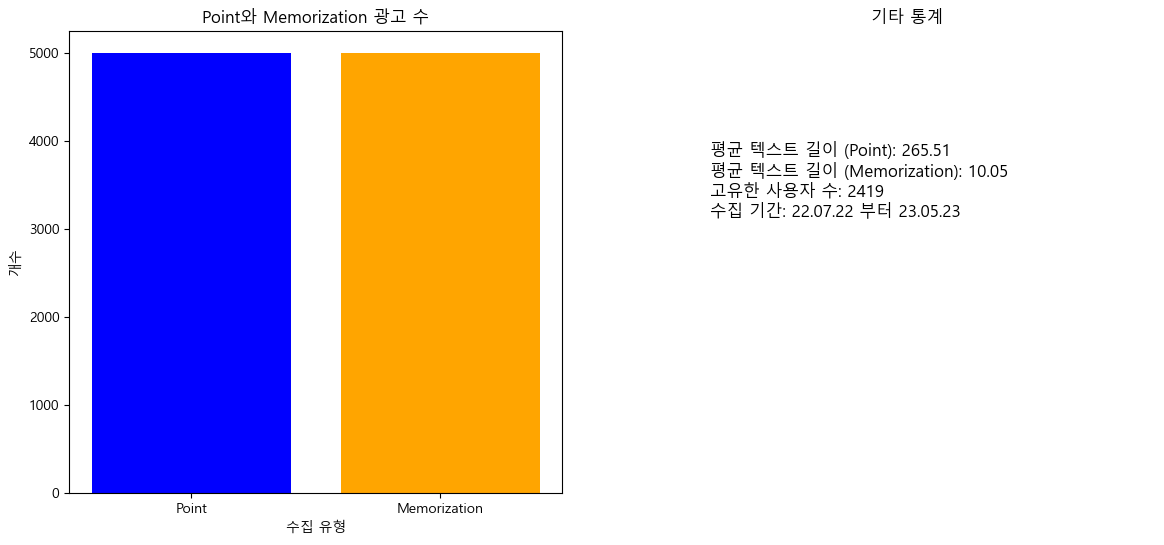

In [12]:
# 더 쉬운 분석을 위해 Spark DataFrame을 Pandas DataFrame으로 변환
pdf = spark_df.toPandas()

# 'Point'와 'Memorization' 광고의 개수
point_count = pdf[pdf['collection'] == 'Point'].shape[0]
memorization_count = pdf[pdf['collection'] == 'Memorization'].shape[0]

# Point, Memorization 각각의 텍스트 평균 길이
avg_text_length_point = pdf[pdf['collection'] == 'Point']['text_length'].mean()
avg_text_length_memorization = pdf[pdf['collection'] == 'Memorization']['text_length'].mean()

# 고유한 사용자 수
unique_users = pdf['public_uid'].nunique()

# 수집된 샘플들의 기간
pdf['created_date'] = pdf['created_timestamp_array'].str.extract(r"(\d{2}\.\d{2}\.\d{2})")
pdf['created_date'] = pd.to_datetime(pdf['created_date'], format='%y.%m.%d')
time_min = pdf['created_date'].min()
time_max = pdf['created_date'].max()

# 그래프 그리기
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Point와 Memorization 개수에 대한 막대 그래프를 그립니다.
axs[0].bar(['Point', 'Memorization'], [point_count, memorization_count], color=['blue', 'orange'])
axs[0].set_title('Point와 Memorization 광고 수')
axs[0].set_xlabel('수집 유형')
axs[0].set_ylabel('개수')

# 기타 통계에 대한 텍스트
stats_text = f"평균 텍스트 길이 (Point): {avg_text_length_point:.2f}\n" \
            f"평균 텍스트 길이 (Memorization): {avg_text_length_memorization:.2f}\n" \
            f"고유한 사용자 수: {unique_users}\n" \
            f"수집 기간: {time_min.strftime('%y.%m.%d')} 부터 {time_max.strftime('%y.%m.%d')}"
axs[1].text(0.1, 0.6, stats_text, fontsize=12)
axs[1].axis('off')
axs[1].set_title('기타 통계')

plt.show()